In [1]:
import pandas as pd

def load_equities_web(symbol, date_from):
    import pandas_datareader.data as web
    raw_data = web.DataReader(symbol, 'yahoo', pd.to_datetime(date_from), pd.datetime.now())
    data = raw_data.stack(dropna=False)['Adj Close'].to_frame().reset_index().rename(columns = {'Symbols':'symbol', 'Date':'date', 'Adj Close':'value'}).sort_values(by = ['symbol', 'date'])
    return pd.pivot_table(data, columns = 'symbol', index = 'date', values ='value')

prices = load_equities_web(['SPY', '^GSPC', '^VIX'], date_from = '2015-01-01')

In [3]:
def backtest_strategy(prices, symbol_trade, symbol_volatility, volatility_threshold, capital, symbol_benchmark):
    
    
    df_init   = (prices[symbol_trade]*0).to_frame().assign(cash = 0)
    df_update = (prices[symbol_trade]*0).to_frame().assign(cash = 0)
    df_end    = (prices[symbol_trade]*0).to_frame().assign(cash = 0)
    
    df_init.iloc[0, df_init.columns.get_loc('cash')] = capital
    df_end.iloc[0, df_end.columns.get_loc('cash')]   = capital
    
    calendar = pd.Series(prices.index).iloc[1:]
    
    for date in calendar:
        prev_date = df_init.index[df_init.index<date][-1]
        
        df_init.loc[date, :] = df_end.loc[prev_date, :]
        
        port_value = df_init.loc[date, symbol_trade] * prices.loc[date, symbol_trade] + df_init.loc[date, 'cash']
        
        if prices.loc[date, symbol_volatility] > volatility_threshold: # volatility is high -> be fully in cash
            df_end.loc[date, symbol_trade] = 0
            df_end.loc[date, 'cash']       = port_value
        else: # volatility is low -> be in market position
            df_end.loc[date, symbol_trade] = port_value/prices.loc[date, symbol_trade]
            df_end.loc[date, 'cash'] = 0
        df_update.loc[date] = df_end.loc[date] - df_init.loc[date]
    
    portval = (df_end*prices.assign(cash = 1)[[symbol_trade, 'cash']]).sum(axis = 1).to_frame().rename(columns = {0:'strategy'})
    portval['benchmark'] = prices[symbol_benchmark]
    portval = portval/portval.iloc[0].values
    
    return portval

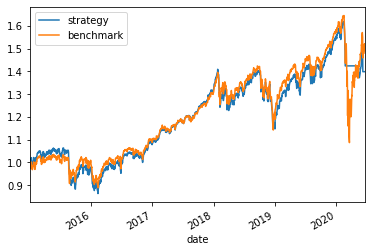

In [5]:
res = backtest_strategy(prices = prices, symbol_trade = 'SPY', symbol_volatility = '^VIX', volatility_threshold = 30, capital = 10000, symbol_benchmark = '^GSPC')
res.plot()